In [1]:
##############################
#
# 09/03/18 setup
#
##############################
from __future__ import division
%matplotlib inline
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from numpy import array
import pandas as pd
import sklearn
import torch
import random
from sklearn.datasets import make_classification
import torch.optim as optim
from functools import reduce
import torch.nn.functional as F
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

# set random seed
# We need to set the cudnn to derministic mode so that 
#we can get consistent result
# Yet, this will slow down the training :( It's a trade-off
# see https://discuss.pytorch.org/t/how-to-
#confugure-pytorch-to-get-deterministic-results/11797
# see https://discuss.pytorch.org/t/network-forward-
#backward-calculation-precision-error/17716/2
random_state = 100
np.random.seed(random_state)
torch.manual_seed(random_state)
random.seed(random_state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('using device ' + str(device))

using device cuda:0


In [2]:
# dataset from the csv files
data_root_dir = '/Users/janaki/Dropbox/bci/bill_grant_Fall2018'
f_name = 'data1_cts_zscored.csv'

# load the feature and labels
df = pd.read_csv('%s/%s' %(data_root_dir, f_name), header=-1)

# define label and feature; convert it to ndarray
# adjust the label from 0 to 9
# y does not have to be one-hot embedding, i.e., if 10 class, then dim is 1000x10, can be 1000,
df_label = df.iloc[:,0]
df_f = df.iloc[:,1:]
X1 = df_f.as_matrix()
X1 = X1.astype(np.float32)
y1 = df_label.as_matrix() 

print(df_label.dtype, y1.shape)
print(X1.shape)


int64 (27987,)
(27987, 192)


C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


0     11026
3      1332
21     1067
28      969
17      921
2       921
25      894
12      881
26      740
8       671
16      661
1       638
31      572
13      568
4       566
9       562
19      535
11      514
32      465
10      418
33      348
27      320
15      297
35      289
18      279
23      263
20      206
22      195
24      180
6       145
7       135
14      117
5        92
29       89
30       66
36       35
34       10
Name: 0, dtype: int64


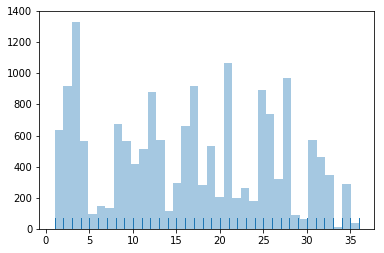

In [3]:
print(df_label.value_counts())
sns.distplot(y1[y1>0], bins = 36, kde=False, rug=True);

In [4]:
#targets for additional layers

y_voicing_conso = np.copy(y1)
y_vowels_lr = np.copy(y1)
y_vowels_ud = np.copy(y1)
y_result = np.copy(y1)

In [5]:
# testing model with only silence,vowel, semivowel and consonant categories for rnn, splitting consonants along voicing for dnn, splitting vowels 

y_vowels_lr[np.where(y1 == 1)] = 2; y_vowels_lr[np.where(y1 == 2)] = 3; y_vowels_lr[np.where(y1 == 3)] = 3; y_vowels_lr[np.where(y1 == 4)] = 2;
y_vowels_lr[np.where(y1 == 5)] = 2; y_vowels_lr[np.where(y1 == 6)] = 3; y_vowels_lr[np.where(y1 == 10)] = 3; y_vowels_lr[np.where(y1 == 11)] = 2;
y_vowels_lr[np.where(y1 == 12)] = 3; y_vowels_lr[np.where(y1 == 16)] = 3; y_vowels_lr[np.where(y1 == 17)] = 3; y_vowels_lr[np.where(y1 == 23)] = 2;
y_vowels_lr[np.where(y1 == 30)] = 2; y_vowels_lr[np.where(y1 == 31)] = 2

y_vowels_ud[np.where(y1 == 1)] = 2; y_vowels_ud[np.where(y1 == 2)] = 2; y_vowels_ud[np.where(y1 == 3)] = 2; y_vowels_ud[np.where(y1 == 4)] = 2;
y_vowels_ud[np.where(y1 == 5)] = 2; y_vowels_ud[np.where(y1 == 6)] = 2; y_vowels_ud[np.where(y1 == 10)] = 2; y_vowels_ud[np.where(y1 == 11)] = 3;
y_vowels_ud[np.where(y1 == 12)] = 3; y_vowels_ud[np.where(y1 == 16)] = 3; y_vowels_ud[np.where(y1 == 17)] = 3; y_vowels_ud[np.where(y1 == 23)] = 3;
y_vowels_ud[np.where(y1 == 30)] = 3; y_vowels_ud[np.where(y1 == 31)] = 3

y1[np.where(y1 == 1)] = 1; y1[np.where(y1 == 2)] = 1; y1[np.where(y1 == 3)] = 1; y1[np.where(y1 == 4)] = 1; 
y1[np.where(y1 == 5)] = 1; y1[np.where(y1 == 6)] = 1; y1[np.where(y1 == 10)] = 1; y1[np.where(y1 == 11)] = 1; 
y1[np.where(y1 == 12)] = 1; y1[np.where(y1 == 16)] = 1; y1[np.where(y1 == 17)] = 1; y1[np.where(y1 == 23)] = 1;
y1[np.where(y1 == 30)] = 1; y1[np.where(y1 == 31)] = 1

y1[np.where(y1 == 19)] = 2; y1[np.where(y1 == 25)] = 2; y1[np.where(y1 == 33)] = 2; y1[np.where(y1 == 34)] = 2; 

#y1[np.where(y1 == 20)] = 4; y1[np.where(y1 == 21)] = 4; y1[np.where(y1 == 22)] = 4; 

y1[y1 > 2] = 3

y_voicing_conso[np.where(y1 == 1)] = 1
y_voicing_conso[np.where(y1 == 2)] = 2
y_vowels_lr[np.where(y1 > 1)] = 1
y_vowels_ud[np.where(y1 > 1)] = 1

y_voicing_conso[np.where(y_voicing_conso == 7)] = 3; y_voicing_conso[np.where(y_voicing_conso == 8)] = 3; y_voicing_conso[np.where(y_voicing_conso == 9)] = 3;
y_voicing_conso[np.where(y_voicing_conso == 14)] = 3; y_voicing_conso[np.where(y_voicing_conso == 20)] = 3; y_voicing_conso[np.where(y_voicing_conso == 21)] = 3; 
y_voicing_conso[np.where(y_voicing_conso == 22)] = 3; y_voicing_conso[np.where(y_voicing_conso == 32)] = 3; y_voicing_conso[np.where(y_voicing_conso == 35)] = 3;
y_voicing_conso[np.where(y_voicing_conso == 36)] = 3

y_voicing_conso[y_voicing_conso > 3] = 4

#y1[np.where(y_voicing_conso == 2)] = 2
#y1[np.where(y_voicing_conso == 3)] = 3

print(np.unique(y1), np.unique(y_voicing_conso), np.unique(y_vowels_lr), np.unique(y_vowels_ud))

[0 1 2 3] [0 1 2 3 4] [0 1 2 3] [0 1 2 3]


In [6]:
#resultant y

y_result[np.intersect1d(np.where(y_vowels_lr == 2) , np.where(y_vowels_ud == 2))] = 1
y_result[np.intersect1d(np.where(y_vowels_lr == 3) , np.where(y_vowels_ud == 2))] = 2
y_result[np.intersect1d(np.where(y_vowels_lr == 2) , np.where(y_vowels_ud == 3))] = 3
y_result[np.intersect1d(np.where(y_vowels_lr == 3) , np.where(y_vowels_ud == 3))] = 4

y_result[np.where(y1 == 2)] = 5
y_result[np.where(y_voicing_conso == 3)] = 6
y_result[np.where(y_voicing_conso == 4)] = 7

In [7]:
y_vowels_lr.size

27987

In [8]:
import collections
counter=collections.Counter(y1)
print(counter)
counter=collections.Counter(y_voicing_conso)
print(counter)
counter=collections.Counter(y_vowels_lr)
print(counter)
counter=collections.Counter(y_vowels_ud)
print(counter)

Counter({0: 11026, 1: 7990, 3: 7184, 2: 1787})
Counter({0: 11026, 1: 7990, 3: 3742, 4: 3442, 2: 1787})
Counter({0: 11026, 1: 8971, 3: 5279, 2: 2711})
Counter({0: 11026, 1: 8971, 2: 4112, 3: 3878})


In [9]:
splits = np.array([0, 3333, 5781, 6666, 9218, 10312, 12292, 14375, 16354, 18958, 20364, 22677, 24062, 25260, 27987])

In [10]:
# calculate class ratio for loss calculation because it is imbalanced

def get_weight_balance(y, amp_weight=1):
    """
    Calculate the class ratio.
    """

    y_labels = np.reshape(y,(y.size,1))
    counts_np = np.bincount(y_labels[:,0])
    
    #counts_np = np.vstack((temp2,temp1[temp2])).T
    max_val = np.max(np.abs(counts_np),axis=0)
    
    class_weight = np.max(np.abs(counts_np),axis=0)/counts_np
    class_weight[1:] = class_weight[1:]*amp_weight
    class_weight = class_weight.tolist()
    
    return class_weight
weight = get_weight_balance(y1,amp_weight = 1)
print(weight)

[1.0, 1.3799749687108886, 6.17011751538892, 1.5347995545657016]


In [11]:
"""
Define the RNN model.
"""
from torch import nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, num_directions, num_layers, hidden_dim, vocab_size, num_chan, batch_size, prob):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.direction = num_directions
        self.batch_size = batch_size
        self.num_layers = num_layers
                
        #first layer lstm cell
        self.lstm = nn.LSTM(input_size = num_chan, hidden_size=hidden_dim, 
                            bidirectional = self.direction>1, num_layers = self.num_layers)  
        self.affine0 = nn.Linear(in_features = num_directions*hidden_dim, 
                                 out_features = vocab_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.dropout = nn.Dropout(p=prob)

    def forward(self, X, hc, **kwargs):
        """
            x: input to the model
                *  x[t] - input of shape (batch, input_size) at time t
                
            hc: hidden and cell states
                *  tuple of hidden and cell state
        """ 
        hc_1 = hc
        output_lstm, (hn, cn) = self.lstm(X, hc_1)
        output_seq = self.affine0(output_lstm)
        
        # return the output sequence
        #pdb.set_trace()  
        #view goes across each row and then traverses down the matrix
        return output_seq.view((X.shape[0]*self.batch_size, self.vocab_size))
    
    def initHidden(self,device = None):
        
        # initialize the hidden state and the cell state to zeros
        #pdb.set_trace()

        return (torch.zeros((self.direction*self.num_layers, self.batch_size, self.hidden_dim), 
                            dtype=torch.float32, device=device),
                torch.zeros((self.direction*self.num_layers, self.batch_size, self.hidden_dim), 
                            dtype=torch.float32, device=device)) 
    

In [12]:
"""
Define the DNN model.
"""
from torch import nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self,  hidden_dim1, hidden_dim2, hidden_dim3, num_output, input_dim):
        super(DNN, self).__init__()
        
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.num_output = num_output
        
        self.nonlin = nn.ReLU()
        self.dense0 = nn.Linear(in_features = input_dim, out_features = self.hidden_dim1)
        self.dense0_bn = nn.BatchNorm1d(self.hidden_dim1)
        self.dense1 = nn.Linear(in_features = self.hidden_dim1, out_features = self.hidden_dim2)
        self.dense1_bn = nn.BatchNorm1d(self.hidden_dim2)
        self.output = nn.Linear(in_features = self.hidden_dim3, out_features = self.num_output)

    def forward(self, X, **kwargs):
        """
            x: input to the model
                *  x[t] - input of shape (batch, input_size) at time t
                
            hc: hidden and cell states
                *  tuple of hidden and cell state
        """ 
        X = self.dense0(X)
        X_1 = self.nonlin(X)
        X_1 = self.dense0_bn(X_1)
        X_1 = self.dense1(X_1)
        X_2 = self.nonlin(X_1)
        X_2 = self.dense1_bn(X_2)
        output_seq = self.output(X_2)
        
        return output_seq.view((X.shape[0], self.num_output))


In [13]:
"""
Train the RNN model
"""
def train_rnn(rnn, input_tensor, target_tensor):
    hidden = rnn.initHidden(device = device)

    optimizer_rnn.zero_grad()
    
    output = rnn(input_tensor.float(), hidden)

    loss = criterion_rnn(output, target_tensor)
    
    # calculate the gradients
    loss.backward()

    # update the parameters of the model
    optimizer_rnn.step()

    return output, loss.item()

In [14]:
"""
Train the DNN model
"""
def train_dnn(dnn, input_tensor, target_tensor):
    
    optimizer_dnn.zero_grad()
    
    dnn = dnn.float()
    
    output = dnn(input_tensor.float())
    #import pdb; pdb.set_trace()
    loss = criterion_dnn(output, target_tensor)
    
    # calculate the gradients
    loss.backward()

    # update the parameters of the model
    optimizer_dnn.step()

    return output, loss.item()

In [15]:
"""
Test the rnn model
"""
def evaluate_rnn(input_tensor):
    rnn.batch_size = 1
    hidden = rnn.initHidden(device = device)
    output = rnn(input_tensor.float(), hidden)
    return output

In [16]:
"""
Test the dnn model
"""
def evaluate_dnn(dnn,input_tensor):
    output = dnn(input_tensor.float())
    return output

In [17]:
"""
Balance dataset labels for classification by subsampling
"""
def subsample(unbalanced_data, unbalanced_labels):
    balanced_labels = torch.tensor([],device = device, dtype=torch.int)
    balanced_data = torch.tensor([],device = device, dtype=torch.float32)
    labels_freq = torch.bincount(unbalanced_labels)
    base_freq = torch.min(labels_freq)
    for label in range(labels_freq.size()[0]):
        print(label)
        ind_label = unbalanced_labels == label
        balanced_labels = torch.cat((balanced_labels, unbalanced_labels[ind_label.nonzero().squeeze()][0:base_freq].int()))
        balanced_data = torch.cat((balanced_data, unbalanced_data[ind_label.nonzero().squeeze(),:][0:base_freq,:].float()))
    return [balanced_data, balanced_labels]

In [18]:
"""
Balance dataset labels for classification by oversampling
"""
def oversample(unbalanced_data, unbalanced_labels):
    balanced_labels = torch.tensor([],device = device, dtype=torch.int)
    balanced_data = torch.tensor([],device = device, dtype=torch.float32)
    labels_freq = torch.bincount(unbalanced_labels)
    base_freq = torch.max(labels_freq)
    for label in range(labels_freq.size()[0]):
        ind_label = unbalanced_labels == label
        for quo in range((base_freq//torch.bincount(ind_label)[1])):
            balanced_labels = torch.cat((balanced_labels, unbalanced_labels[ind_label.nonzero().squeeze()].int()))
            balanced_data = torch.cat((balanced_data, unbalanced_data[ind_label.nonzero().squeeze(),:].float()))
        rem = base_freq % torch.bincount(ind_label)[1]
        balanced_labels = torch.cat((balanced_labels, unbalanced_labels[ind_label.nonzero().squeeze()][0:rem].int()))
        balanced_data = torch.cat((balanced_data, unbalanced_data[ind_label.nonzero().squeeze(),:][0:rem].float()))
            
    return [balanced_data, balanced_labels]

In [19]:
import time
t0 = time.time()

# define the input data
X_raw = X1
y = y1

# input X matrix dimensions: length, batch size, features
X_raw = np.expand_dims(X_raw.astype(np.float32), axis=1)
y = y.astype(np.int64)

print(X_raw.shape, y.shape)

#define output variables
out_proba_mat = np.zeros((y.shape[0],len(np.unique(y))))  #contains probabilities
val_mat = np.zeros_like(y)  #contains value determined using the highest probability 

#converting to torch variables
y_gpu = torch.tensor(y, dtype=torch.long, device=device)
X_raw_gpu = torch.tensor(X_raw, device=device)

(27987, 1, 192) (27987,)


C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

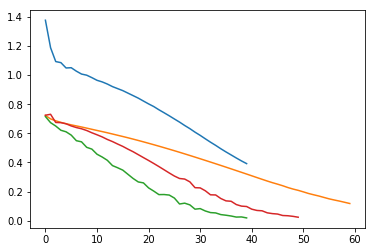

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

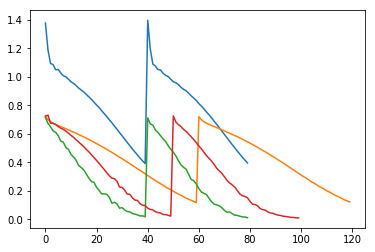

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

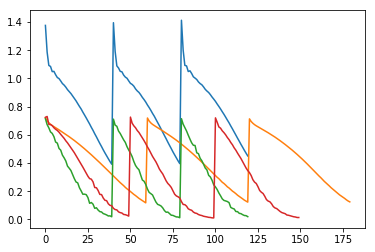

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

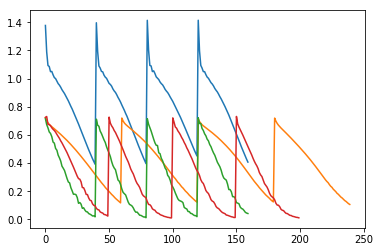

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

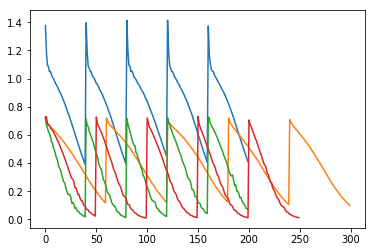

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

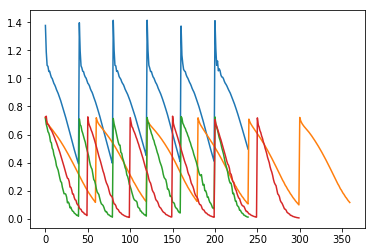

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

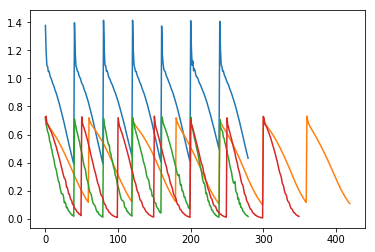

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

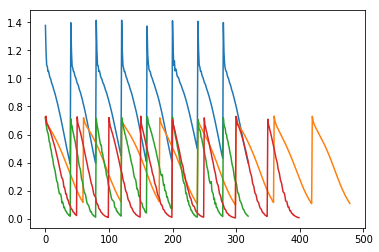

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

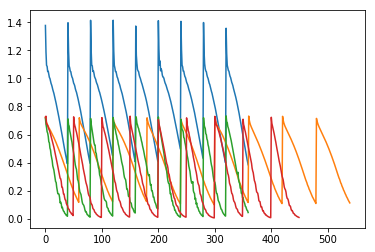

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

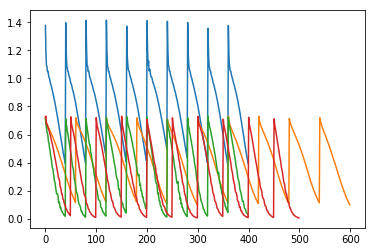

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

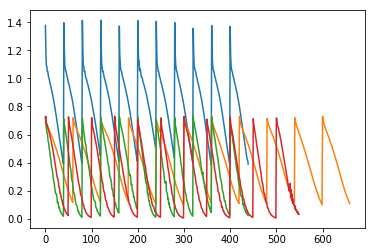

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

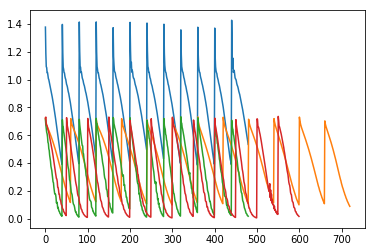

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

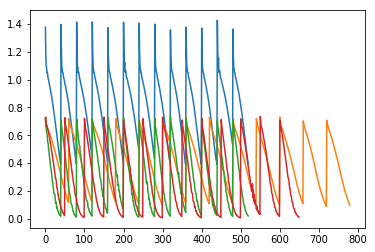

C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\janaki\Miniconda3\envs\janaki_gpu\lib\site-packages\ipykernel_launcher.py:156: UserWarning: To copy construct from a tensor, it is recommende

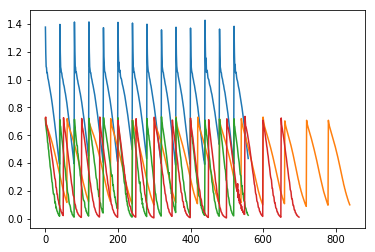

In [20]:
#defining rnn parameters
n_hidden = 128

#variables for visualization
print_every = 30
plot_every = 1
val_every = 1
current_tr_loss = 0
current_val_loss = 0
val_loss = 0
cnt = 0 
all_rnn_losses = []
all_dnn_voicing_losses = []
all_dnn_vowels_lr_losses = []
all_dnn_vowels_ud_losses = []
all_val_losses = []
itr_rnn = 40
itr_dnn_vo = 60
itr_dnn_vw = 50

#assigning weights to each class for the base rnn
class_weight_rnn = get_weight_balance(y, amp_weight=1)
class_weight_rnn = torch.tensor(class_weight_rnn, device = device, dtype=torch.float32)

for split_test in np.arange(splits.shape[0]-1):
    
    val_samples = [X_raw_gpu[splits[split_test]:splits[split_test+1],:,:], y_gpu[splits[split_test]:splits[split_test+1]]]
       
    #training values
    split_train = np.delete(np.arange(y.shape[0]), np.arange(splits[split_test],splits[split_test+1]))
    input_X_meta = X_raw_gpu[split_train,:,:]
    input_y_meta = y_gpu[split_train] 
    
    [input_X_meta_balanced, input_y_meta_balanced] = oversample(input_X_meta, input_y_meta)
    s = np.arange(input_y_meta_balanced.shape[0])
    np.random.shuffle(s)
    input_X_meta_balanced = input_X_meta_balanced[s,:,:]
    input_y_meta_balanced = input_y_meta_balanced[s]
    input_y_meta_balanced = torch.tensor(input_y_meta_balanced, dtype=torch.long, device=device)    
    
    #Base case RNN model
    rnn = RNN(num_layers = 1, num_directions = 2, hidden_dim = 128, vocab_size = 4, num_chan = 192, batch_size = 1, prob = 0)  
    rnn = rnn.to(device)
    criterion_rnn = nn.CrossEntropyLoss(weight = class_weight_rnn)
    optimizer_rnn = optim.Adam(rnn.parameters(), lr=0.007)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma=0.1, last_epoch=-1)
        
    for iter in np.arange(itr_rnn):
        
        output, loss_rnn = train_rnn(rnn, input_X_meta_balanced, input_y_meta_balanced)
        #scheduler.step()
        cnt += 1
        all_rnn_losses.append(loss_rnn)

        # Print iter number, loss, name and guess
        #if cnt % print_every == 0:
            #out_proba_val = F.softmax(output, dim=-1)  
            #out_proba_val = out_proba_val.cpu().detach().numpy()
            #print(np.argmax(out_proba_val,axis=1))
            #print(input_y)   
    
    #Consonants voicing-based DNN model
    y_voicing_conso_train = y_voicing_conso[split_train]
    mask = y_voicing_conso_train > 2
    mask = torch.from_numpy(np.array(mask, dtype=np.uint8))
    input_y_voicing_conso_gpu = torch.tensor(y_voicing_conso_train, dtype=torch.long, device=device)
    
    input_X_voicing = torch.squeeze(input_X_meta[mask,:,:])
    input_y_voicing = input_y_voicing_conso_gpu[mask]
    
    input_y_voicing -= 3
    
    [input_X_voicing_balanced, input_y_voicing_balanced] = oversample(input_X_voicing, input_y_voicing)
    s = np.arange(input_y_voicing_balanced.shape[0])
    np.random.shuffle(s)
    input_X_voicing_balanced = input_X_voicing_balanced[s,:]
    input_y_voicing_balanced = input_y_voicing_balanced[s]
    
    dnn_voicing = DNN(hidden_dim1 = 128, hidden_dim2 = 64, hidden_dim3 = 64, num_output = 2, input_dim = input_X_voicing_balanced.shape[1])  
    dnn_voicing = dnn_voicing.to(device)
    
    #assigning weights to each class for the voicing dnn
    class_weight_dnn = get_weight_balance(input_y_voicing_balanced.cpu().detach().numpy(), amp_weight=1) #this is hackery, went from torch to cpu to torch
    class_weight_dnn = torch.tensor(class_weight_dnn, device = device, dtype=torch.float32)
    criterion_dnn = nn.CrossEntropyLoss(weight = class_weight_dnn)
    optimizer_dnn = optim.Adam(dnn_voicing.parameters(), lr=0.001)

    input_y_voicing_balanced = torch.tensor(input_y_voicing_balanced, dtype=torch.long, device=device)

    for iter in np.arange(itr_dnn_vo):
        
        output, loss_dnn_voicing = train_dnn(dnn_voicing, input_X_voicing_balanced, input_y_voicing_balanced)
        cnt += 1
        all_dnn_voicing_losses.append(loss_dnn_voicing)  
        
    #Vowels left right DNN model
    y_vowels_lr_train = y_vowels_lr[split_train]
    mask_vowel_lr = y_vowels_lr_train > 1
    mask_vowel_lr = torch.from_numpy(np.array(mask_vowel_lr, dtype=np.uint8))
    input_y_vowels_lr_gpu = torch.tensor(y_vowels_lr_train, dtype=torch.long, device=device)

    input_X_vowels_lr = torch.squeeze(input_X_meta[mask_vowel_lr,:,:])
    input_y_vowels_lr = input_y_vowels_lr_gpu[mask_vowel_lr]

    input_y_vowels_lr -= 2
    
    [input_X_vowels_lr_balanced, input_y_vowels_lr_balanced] = oversample(input_X_vowels_lr, input_y_vowels_lr)
    s = np.arange(input_y_vowels_lr_balanced.shape[0])
    np.random.shuffle(s)
    input_X_vowels_lr_balanced = input_X_vowels_lr_balanced[s,:]
    input_y_vowels_lr_balanced = input_y_vowels_lr_balanced[s]
    
    dnn_vowels_lr = DNN(hidden_dim1 = 64, hidden_dim2 = 64, hidden_dim3 = 64, num_output = 2, input_dim = input_X_vowels_lr_balanced.shape[1])  
    dnn_vowels_lr = dnn_vowels_lr.to(device)
    
    #assigning weights to each class for the vowels dnn
    class_weight_dnn_lr = get_weight_balance(input_y_vowels_lr_balanced.cpu().detach().numpy(), amp_weight=1) #this is hackery, went from torch to cpu to torch
    class_weight_dnn_lr = torch.tensor(class_weight_dnn_lr, device = device, dtype=torch.float32)
    criterion_dnn = nn.CrossEntropyLoss(weight = class_weight_dnn_lr)
    optimizer_dnn = optim.Adam(dnn_vowels_lr.parameters(), lr=0.01)

    input_y_vowels_lr_balanced = torch.tensor(input_y_vowels_lr_balanced, dtype=torch.long, device=device)

    for iter in np.arange(40):
        
        output, loss_dnn_vowels_lr = train_dnn(dnn_vowels_lr, input_X_vowels_lr_balanced, input_y_vowels_lr_balanced)
        cnt += 1
        all_dnn_vowels_lr_losses.append(loss_dnn_vowels_lr)    
        
    #Vowels up down DNN model
    y_vowels_ud_train = y_vowels_ud[split_train]
    mask_vowel_ud = y_vowels_ud_train > 1
    mask_vowel_ud = torch.from_numpy(np.array(mask_vowel_ud, dtype=np.uint8))
    input_y_vowels_ud_gpu = torch.tensor(y_vowels_ud_train, dtype=torch.long, device=device)

    input_X_vowels_ud = torch.squeeze(input_X_meta[mask_vowel_ud,:,:])
    input_y_vowels_ud = input_y_vowels_ud_gpu[mask_vowel_ud]

    input_y_vowels_ud -= 2
    
    [input_X_vowels_ud_balanced, input_y_vowels_ud_balanced] = oversample(input_X_vowels_ud, input_y_vowels_ud)
    s = np.arange(input_y_vowels_ud_balanced.shape[0])
    np.random.shuffle(s)
    input_X_vowels_ud_balanced = input_X_vowels_ud_balanced[s,:]
    input_y_vowels_ud_balanced = input_y_vowels_ud_balanced[s]
    
    dnn_vowels_ud = DNN(hidden_dim1 = 128, hidden_dim2 = 64, hidden_dim3 = 64, num_output = 2, input_dim = input_X_vowels_ud_balanced.shape[1])  
    dnn_vowels_ud = dnn_vowels_ud.to(device)
    
    #assigning weights to each class for the vowels dnn
    class_weight_dnn_ud = get_weight_balance(input_y_vowels_ud_balanced.cpu().detach().numpy(), amp_weight=1) #this is hackery, went from torch to cpu to torch
    class_weight_dnn_ud = torch.tensor(class_weight_dnn_ud, device = device, dtype=torch.float32)
    criterion_dnn = nn.CrossEntropyLoss(weight = class_weight_dnn_ud)
    optimizer_dnn = optim.Adam(dnn_vowels_ud.parameters(), lr=0.004)

    input_y_vowels_ud_balanced = torch.tensor(input_y_vowels_ud_balanced, dtype=torch.long, device=device)

    for iter in np.arange(50):
        
        output, loss_dnn_vowels_ud = train_dnn(dnn_vowels_ud, input_X_vowels_ud_balanced, input_y_vowels_ud_balanced)
        cnt += 1
        all_dnn_vowels_ud_losses.append(loss_dnn_vowels_ud)         
        
    # validation step
    val_X = val_samples[0]
    val_y = val_samples[1] 

    output_rnn = evaluate_rnn(val_X)
    out_proba_val_rnn = F.softmax(output_rnn, dim=-1)  
    out_proba_val_rnn = out_proba_val_rnn.cpu().detach().numpy()
    
    output_dnn_voicing = evaluate_dnn(dnn_voicing, torch.squeeze(val_X))
    out_proba_val_dnn_voicing = F.softmax(output_dnn_voicing, dim=-1)  
    out_proba_val_dnn_voicing = out_proba_val_dnn_voicing.cpu().detach().numpy()
    
    output_dnn_vowels_lr = evaluate_dnn(dnn_vowels_lr, torch.squeeze(val_X))
    out_proba_val_dnn_vowels_lr = F.softmax(output_dnn_vowels_lr, dim=-1)  
    out_proba_val_dnn_vowels_lr = out_proba_val_dnn_vowels_lr.cpu().detach().numpy()
    
    output_dnn_vowels_ud = evaluate_dnn(dnn_vowels_ud, torch.squeeze(val_X))
    out_proba_val_dnn_vowels_ud = F.softmax(output_dnn_vowels_ud, dim=-1)  
    out_proba_val_dnn_vowels_ud = out_proba_val_dnn_vowels_ud.cpu().detach().numpy()
        
    out_proba_mat[splits[split_test]:splits[split_test+1],:] = out_proba_val_rnn
    values_from_rnn = np.argmax(out_proba_val_rnn,axis=1)
    
    val_mat[splits[split_test]:splits[split_test+1]] = values_from_rnn
    val_mat[splits[split_test]:splits[split_test+1]][np.where(values_from_rnn == 3)] = np.argmax(out_proba_val_dnn_voicing[np.where(values_from_rnn == 3)], axis = 1) + 6
    val_mat[splits[split_test]:splits[split_test+1]][np.where(values_from_rnn == 2)] = 5
    val_vowels = np.zeros([np.sum(values_from_rnn == 1),4])    
    val_vowels[:,0] = np.multiply(out_proba_val_dnn_vowels_lr[np.where(values_from_rnn == 1),0] , out_proba_val_dnn_vowels_ud[np.where(values_from_rnn == 1),0])
    val_vowels[:,1] = np.multiply(out_proba_val_dnn_vowels_lr[np.where(values_from_rnn == 1),1] , out_proba_val_dnn_vowels_ud[np.where(values_from_rnn == 1),0])  
    val_vowels[:,2] = np.multiply(out_proba_val_dnn_vowels_lr[np.where(values_from_rnn == 1),0] , out_proba_val_dnn_vowels_ud[np.where(values_from_rnn == 1),1])
    val_vowels[:,3] = np.multiply(out_proba_val_dnn_vowels_lr[np.where(values_from_rnn == 1),1] , out_proba_val_dnn_vowels_ud[np.where(values_from_rnn == 1),1])
    
    val_mat[splits[split_test]:splits[split_test+1]][np.where(values_from_rnn == 1)] = np.argmax(val_vowels, axis = 1) + 1
    #val_mat[splits[split_test]:splits[split_test+1]][np.where(values_from_rnn == 1)] = np.argmax(out_proba_val_dnn_vowels[np.where(values_from_rnn == 1)], axis = 1)+1

    plt.plot(all_rnn_losses)
    plt.plot(all_dnn_voicing_losses)
    plt.plot(all_dnn_vowels_lr_losses)
    plt.plot(all_dnn_vowels_ud_losses)
    plt.show()
    #print(y[splits[split_test]:splits[split_test+1]])
    #print(val_mat[splits[split_test]:splits[split_test+1]])
t1 = time.time()
total = t1-t0    
    

[[5197  231  352  310  444 2323 1063 1106]
 [ 128  119  108  105  130  389  171  146]
 [ 226  231  316  259  265  836  343  340]
 [ 119  105  156  137  129  386  220  163]
 [ 176  163  271  228  265  701  338  321]
 [ 203  117  115   97  117  561  306  271]
 [ 424  161  238  198  247 1139  759  576]
 [ 487  143  197  192  255  950  654  564]]
confusion matrix
0.19505180237951786
0.17295046250305318


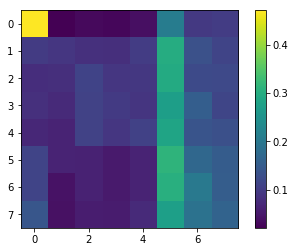

In [21]:
y_col = y_result.reshape(y_result.size,1)
val_col = val_mat.reshape(val_mat.size,1)


"""
Evaluate the performance
"""
from sklearn.metrics import confusion_matrix

# calculation the confusion matrix
# row: true label
# col: predicted value
cm = np.array(confusion_matrix(y_col,val_col))
print(cm)
row_sum = np.sum(cm, axis = 1)
cm = cm/row_sum[:,None]

np.set_printoptions(threshold=np.inf)

#print(df.iloc[:,0].value_counts())

print('confusion matrix')
image = plt.imshow(cm[0:,0:])
plt.colorbar()
print(np.sum(cm.diagonal())/np.sum(cm))
print(np.sum(cm[1:,1:].diagonal())/np.sum(cm[1:,1:]))

In [22]:
#plt.savefig('512_units,30_itr,layers_1,5ms_lr_vowelsconso.jpg')

In [23]:
class_weight_dnn

tensor([1., 1.], device='cuda:0')

In [24]:
np.mean(X_raw, axis = 2).shape

(27987, 1)

In [25]:
np.unique(y_result)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)